## Interpolate data and plot maps in different projections

Here we will show how to plot ICON data (and any unstructured and structured data for that matter) on a map with different projections. It's a simple way not to wait for ages while your cartopy script will plot one time step. As a bonus we show at the end how to create netCDF file from your interpolated data, that you can animate with ncview.

We will use a small library, called `nereus`, located two levels up from this notebook. It's just a collection of helper functions, that makes code more compact.

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import glob
import intake
from pathlib import Path
import pyicon as pyic
import dask
import cmocean.cm as cmo
import pandas as pd
dask.config.set({"array.slicing.split_large_chunks": True}) 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
sys.path.append("../../")
import nereus as nr

We are going to work with daily ICON files

In [3]:
run_folder = Path("/work/bm1344/k203123/experiments/erc1011/run_20080101T000000-20080131T235845/")

data_atm = xr.open_dataset(run_folder / "erc1011_atm_ml_1d_mean_1_20080103T000000Z.nc")
data_oce = xr.open_dataset(run_folder / "erc1011_oce_ml_1d_mean_20080102T000000Z.nc")

def prep_data(ds):
    ds = ds.rename({"ncells": "cell"})
    return ds

data_oce = prep_data(data_oce)
data_oce

<xarray.Dataset>
Dimensions:  (time: 1, depth: 72, depth_2: 73, cell: 14886338)
Coordinates:
  * time     (time) datetime64[ns] 2008-01-02
  * depth    (depth) float64 1.0 3.1 5.45 8.1 ... 5.279e+03 5.546e+03 5.816e+03
  * depth_2  (depth_2) float64 0.0 2.0 4.2 6.7 ... 5.412e+03 5.681e+03 5.951e+03
Dimensions without coordinates: cell
Data variables:
    to       (time, depth, cell) float32 ...
    so       (time, depth, cell) float32 ...
    u        (time, depth, cell) float32 ...
    v        (time, depth, cell) float32 ...
    w        (time, depth_2, cell) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 2.2.0 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  16
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          375cb0cc-637e-11e8-9d6f-8f41a9b9ff4b
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-mpim.git@450227788f06e...
    history:              ./icon at 20231005 005908
    references:           see MPIM/DWD publications
    comment:              Sapphire Dyamond (k203123) on l40584 (Linux 4.18.0-...

## Open the grid
The raw ICON grid has some less than useful variable names and units. We use the `pyicon` `convert_tgrid` function to put it into a friendlier format with good names and units.

In [68]:
grid = xr.open_dataset("/pool/data/ICON/grids/public/mpim/0016/icon_grid_0016_R02B09_O.nc", chunks="auto")
grid = pyic.convert_tgrid_data(grid)
grid

<xarray.Dataset>
Dimensions:                 (cell: 14886338, vertex: 7487687, edge: 22375924,
                             nc_e: 2, nv_c: 3, ne_c: 3, nv_v: 6, ne_v: 6,
                             nv_e: 2, nc_v: 6, nc_c: 3, cart: 3)
Coordinates:
    clon                    (cell) float64 dask.array<chunksize=(14886338,), meta=np.ndarray>
    clat                    (cell) float64 dask.array<chunksize=(14886338,), meta=np.ndarray>
    vlon                    (vertex) float64 dask.array<chunksize=(7487687,), meta=np.ndarray>
    vlat                    (vertex) float64 dask.array<chunksize=(7487687,), meta=np.ndarray>
    elon                    (edge) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
    elat                    (edge) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
Dimensions without coordinates: cell, vertex, edge, nc_e, nv_c, ne_c, nv_v,
                                ne_v, nv_e, nc_v, nc_c, cart
Data variables: (12/40)
    grid_sphere_radius      float64 6.371e+06
    grav                    float64 9.807
    earth_angular_velocity  float64 7.292e-05
    rho0                    float64 1.025e+03
    rhoi                    float64 917.0
    rhos                    float64 300.0
    ...                      ...
    edge_cart_vec           (edge, cart) float64 dask.array<chunksize=(16777216, 1), meta=np.ndarray>
    dual_edge_cart_vec      (edge, cart) float64 dask.array<chunksize=(16777216, 1), meta=np.ndarray>
    edge_prim_norm          (edge, cart) float64 dask.array<chunksize=(16777216, 1), meta=np.ndarray>
    fc                      (cell) float64 dask.array<chunksize=(14886338,), meta=np.ndarray>
    fe                      (edge) float64 dask.array<chunksize=(16777216,), meta=np.ndarray>
    fv                      (vertex) float64 dask.array<chunksize=(7487687,), meta=np.ndarray>
Attributes:
    converted_tgrid:  True

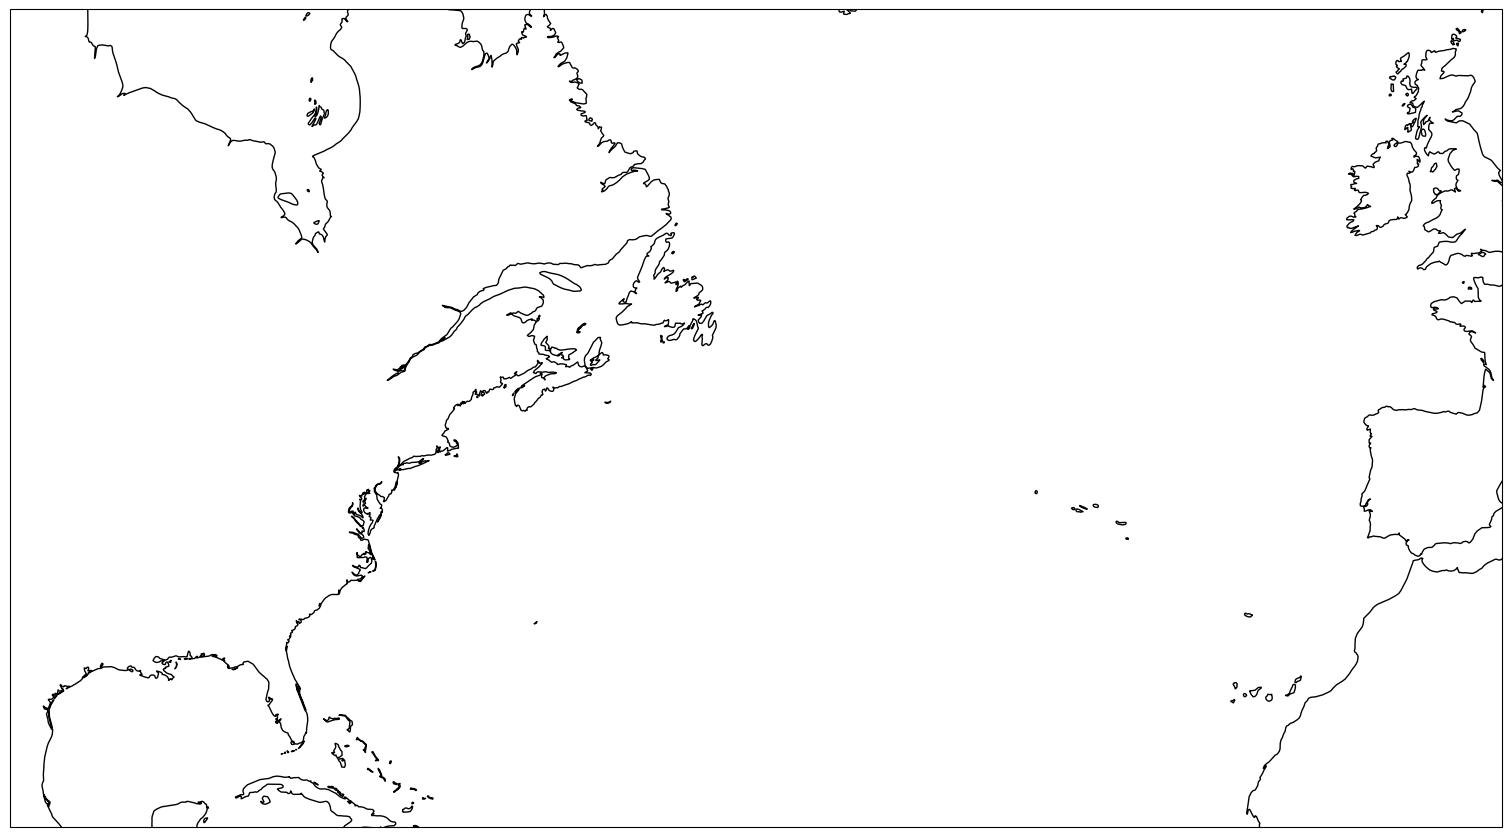

In [33]:
bbox = [-100, 0, 20, 60]

fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.Mercator()),
            constrained_layout=True,
            figsize=(15,10),
        )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
ax.coastlines("50m")

In [34]:
x, y, lon2, lat2 = nr.projected_grid_to_platecarree_pyproj(bbox, [1000, 500], projection="World_Mercator", n_points=100)

In [36]:
distances, inds = nr.create_indexes_and_distances(grid["clon"].values, grid["clat"].values, lon2, lat2, k=1, workers=10)

In [37]:
data_sample = data_oce["to"].isel(depth=0, time=-1)

radius_of_influence = 10000
data_interpolated = data_sample.values[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

In [38]:
data_interpolated

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., 6.946687698364258, 6.833295822143555,
         6.615699291229248],
        [--, --, --, ..., 6.967899322509766, 6.970100402832031,
         6.8676676750183105],
        [--, --, --, ..., 6.976912021636963, 6.976943492889404,
         6.873581409454346]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)

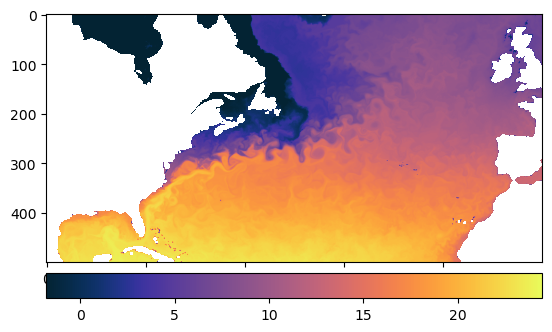

In [39]:
plt.imshow(np.flipud(data_interpolated), cmap=cmo.thermal)
plt.colorbar(orientation='horizontal', pad=0.03)

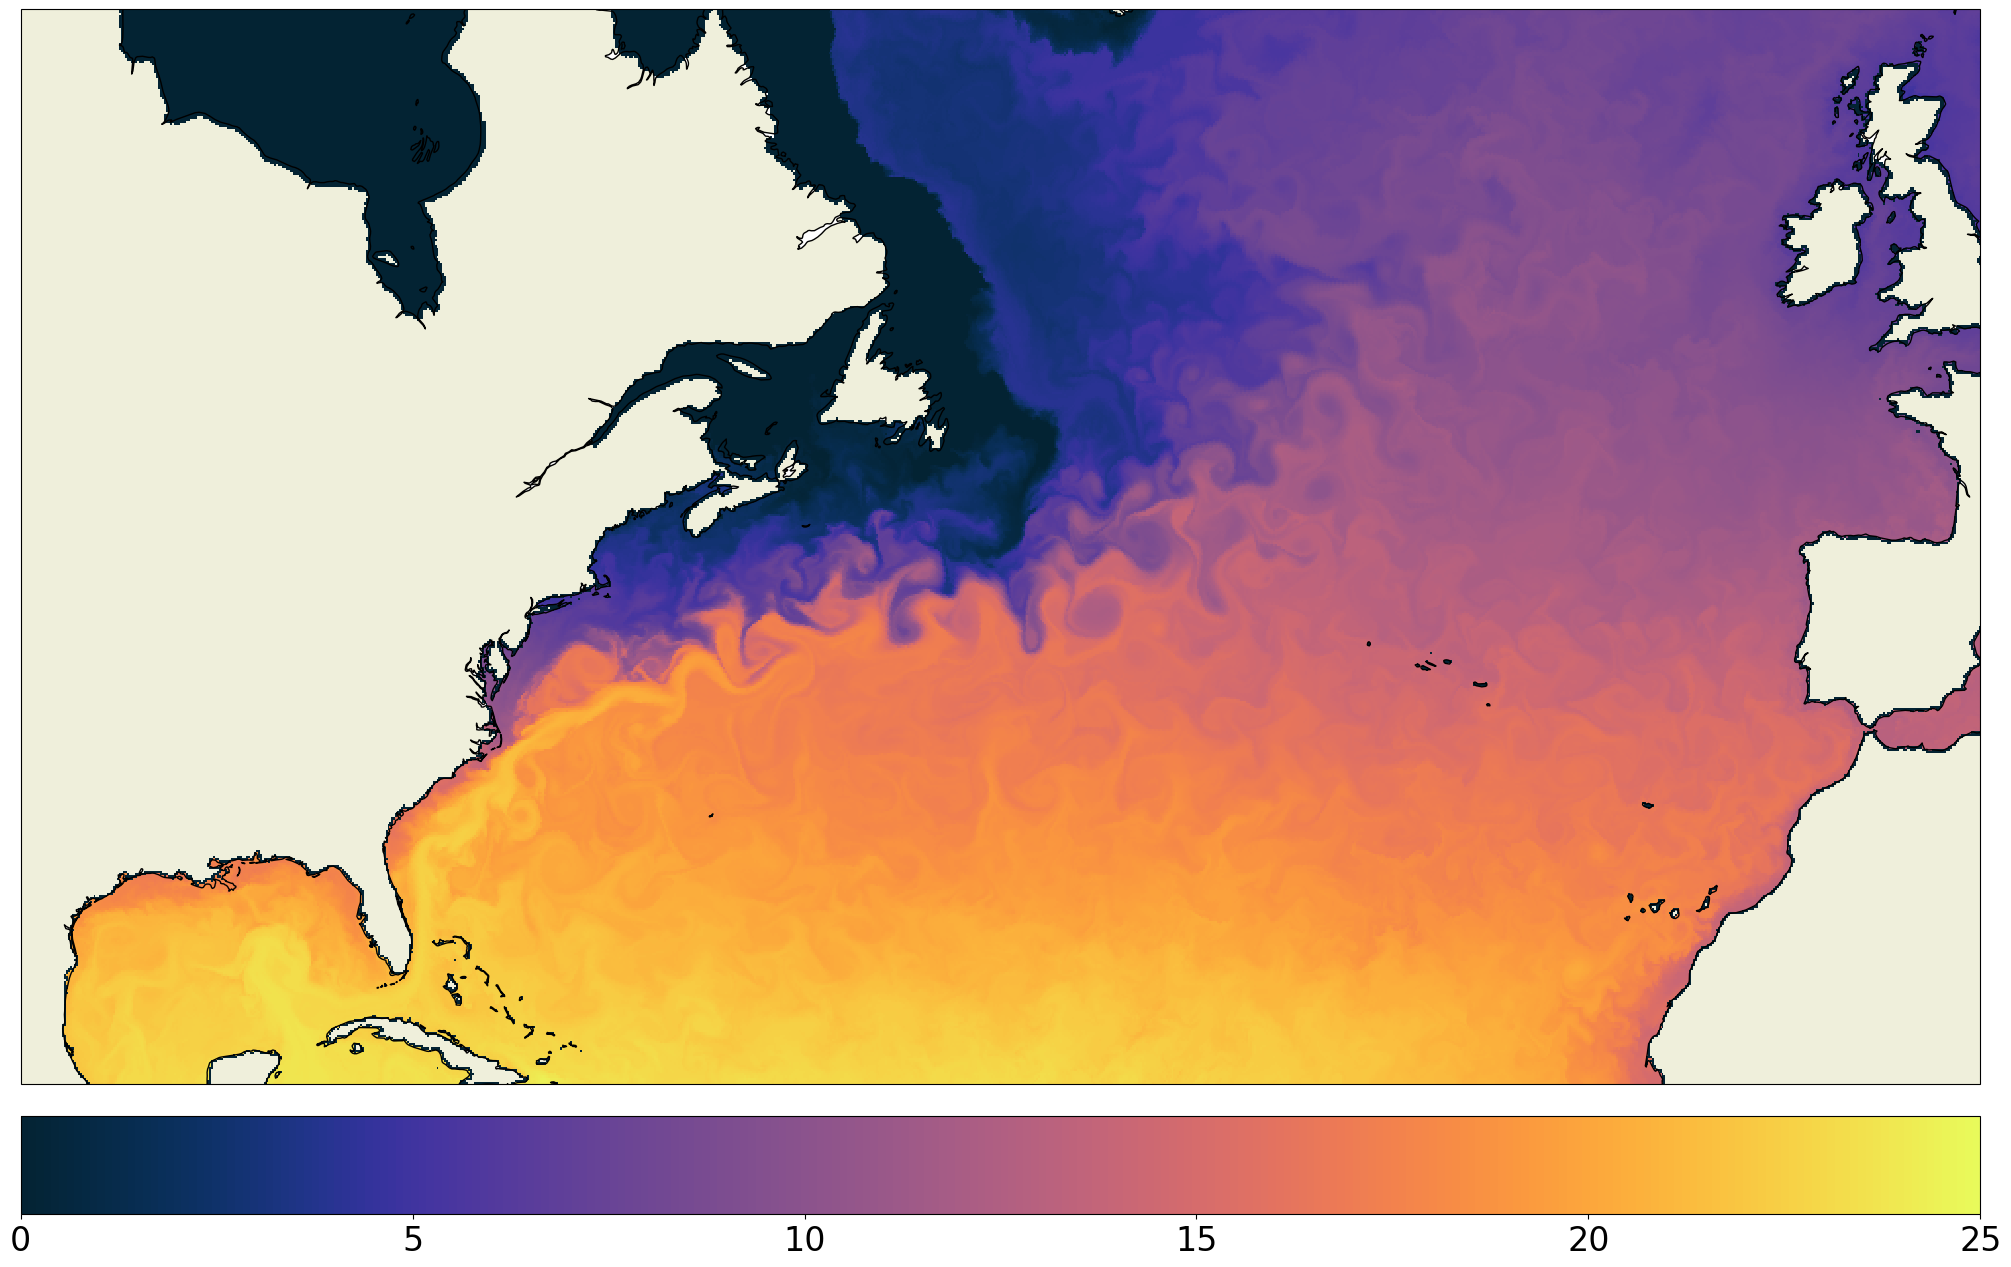

In [40]:
projection_ccrs = ccrs.Mercator()
fig, ax = plt.subplots(
                    1,
                    1,
                    subplot_kw=dict(projection=ccrs.Mercator()),
                    constrained_layout=True,
                    figsize=(20, 30),
                )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
im1 = ax.imshow(np.flipud(data_interpolated), cmap=cmo.thermal,
                vmin=0, vmax=25,
                extent=(x.min(), x.max(), y.min(), y.max()),
                interpolation='nearest', 
               transform=ccrs.Mercator())
ax.coastlines()
cb = fig.colorbar(im1, orientation='horizontal', pad=0.01)
cb.ax.tick_params(labelsize=24)
ax.add_feature(cfeature.LAND)

## North Polar stereo projection

In [41]:
bbox = [-180, 180, 60, 90]

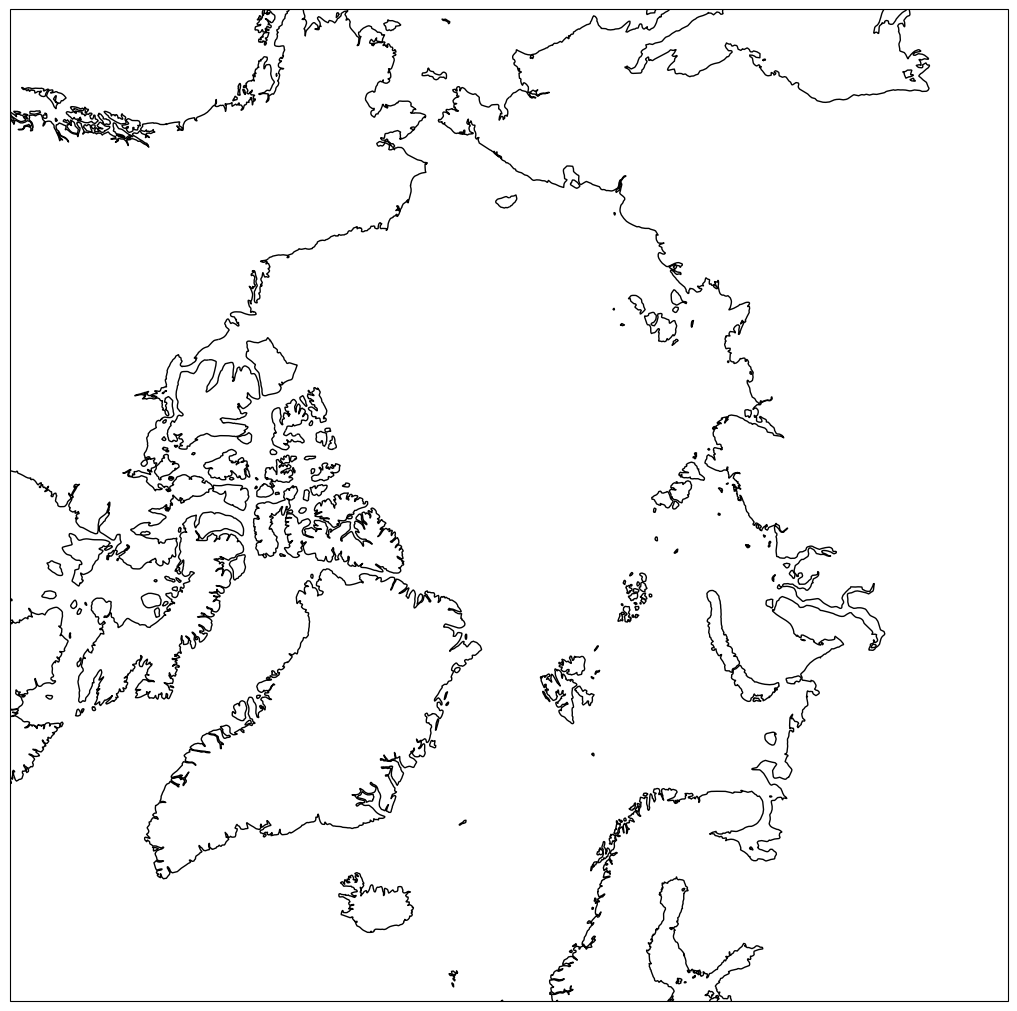

In [42]:
fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.NorthPolarStereo()),
            constrained_layout=True,
            figsize=(15,10),
        )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
ax.coastlines()

We need to define NP projection to match the one from cartopy

In [43]:
from pyproj import CRS

In [44]:
custom_north_polar_stereo = CRS.from_string("+proj=stere +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [45]:
x, y, lon2, lat2 = nr.projected_grid_to_platecarree_pyproj(bbox, [500, 500], projection=custom_north_polar_stereo, n_points=100)

In [46]:
distances, inds = nr.create_indexes_and_distances(grid["clon"].values, grid["clat"].values, lon2, lat2, k=1, workers=10)

In [57]:
data_sample = data_oce["so"].isel(time=-1, depth=0)

radius_of_influence=5000
data_interpolated = data_sample.values[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(lon2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

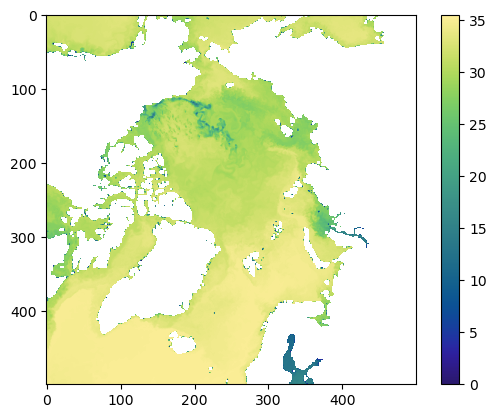

In [58]:
# plt.figure(figsize=(15,15))
plt.imshow(np.flipud(data_interpolated), cmap=cmo.haline)
plt.colorbar()

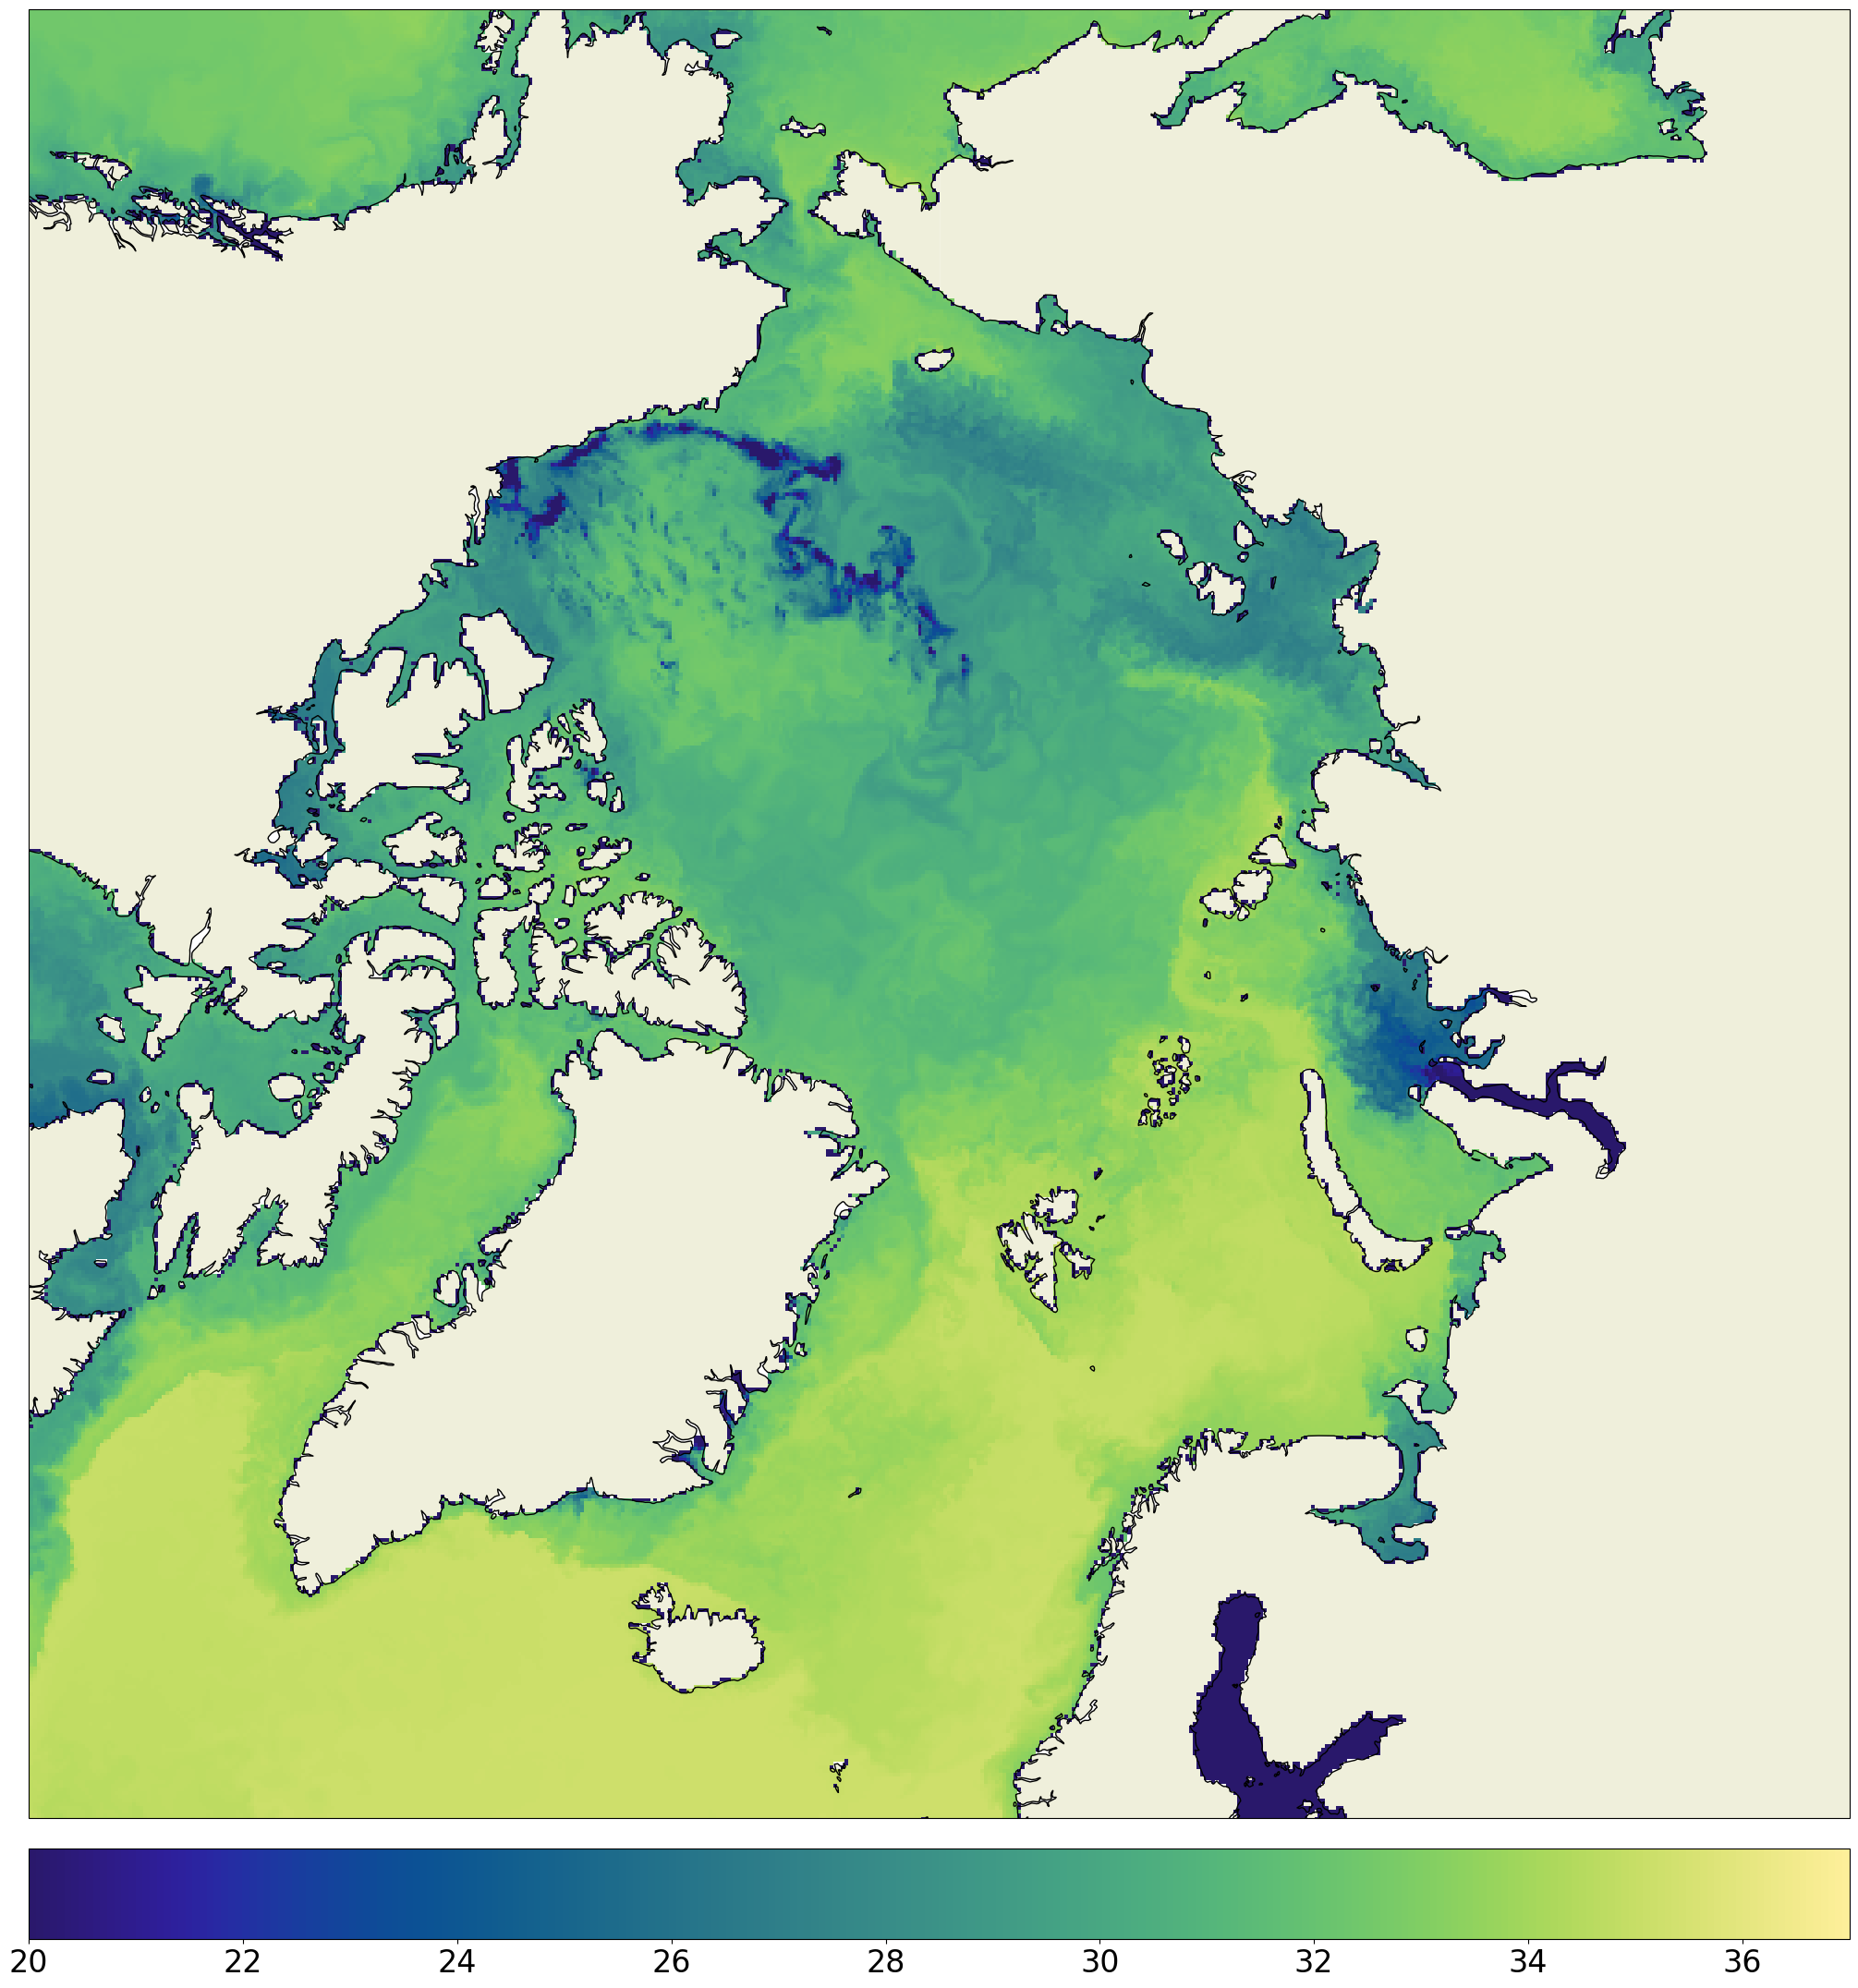

In [62]:
projection_ccrs = ccrs.NorthPolarStereo()
fig, ax = plt.subplots(
                    1,
                    1,
                    subplot_kw=dict(projection=ccrs.NorthPolarStereo()),
                    constrained_layout=True,
                    figsize=(20, 30),
                )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
im1 = ax.imshow(np.flipud(data_interpolated), cmap=cmo.haline,
                vmin=20, vmax=37,
                extent=(x.min(), x.max(), y.min(), y.max()),
                interpolation='nearest', 
               transform=ccrs.NorthPolarStereo())
ax.coastlines()
cb = fig.colorbar(im1, orientation='horizontal', pad=0.01)
cb.ax.tick_params(labelsize=24)
ax.add_feature(cfeature.LAND)

## Interpolate data in NP stereo and save them as netCDF

In [63]:
import xarray as xr

We reuse arrays created for NP stereo example here. Only first 365 time steps interpolated, which takes about a minute.

In [64]:
%%time
data_interpolated_array = []
for i in range(72):
    data_sample = data_oce["to"].isel(time=-1, depth=i)

    radius_of_influence=5000
    data_interpolated = data_sample.values[inds]
    data_interpolated[distances >= radius_of_influence] = np.nan
    data_interpolated = data_interpolated.reshape(lon2.shape)
    data_interpolated = np.ma.masked_invalid(data_interpolated)
    data_interpolated_array.append(data_interpolated)

CPU times: user 587 ms, sys: 2.67 s, total: 3.26 s
Wall time: 3.66 s


In [65]:
data_interpolated_array = np.array(data_interpolated_array, dtype="float32")

In [66]:
out = xr.Dataset(
        {"to": (["depth", "lat", "lon"], data_interpolated_array)},
        coords={
            "time": data_oce["time"].values,
            "depth": data_oce["depth"].values,
            "lon": (["lon"], x),
            "lat": (["lat"], y),
            "longitude": (["lat", "lon"], lon2),
            "latitude": (["lat", "lon"], lat2),
        },
        # attrs=data.attrs,
    )

In [67]:
out.to_netcdf('./out.nc')